In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import csv
import numpy as np
import re
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 30.2MB/s 
     |████████████████████████████████| 552kB 48.8MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=5351a8740ea6e4930046e7344c726431b23fbc39320dd77a63f961fb7429028b
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32040 sha256=16f06e0081003011878afa367f1760ebd67b0c855a5e9627caf05b90e8a3e0b8
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [0]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [0]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [0]:
segments= pd.read_csv("/content/drive/My Drive/Colab Notebooks/FYP/gdprSegments.csv")
segments = segments["0"].tolist()

In [7]:
len(segments)

371

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(segments)
counts = np.asarray(X.toarray())
avg_word_count = float(np.sum(np.sum(counts, axis=1)))/len(segments)
print(avg_word_count)

75.11051212938006


In [0]:
#data preprocessing, removing commas and numbers
data = [re.sub("\'", "", sent) for sent in segments]
data = [re.sub("\(", "", sent) for sent in data]
data = [re.sub("\)", "", sent) for sent in data]
data = [re.sub(",", "", sent) for sent in data]
data = [re.sub(";", "", sent) for sent in data]
for i in range(0,9):
  data = [re.sub(str(i), "", sent) for sent in data]
data

In [0]:
def sent_to_words(segments_list):
    for seg in segments_list:
        yield(gensim.utils.simple_preprocess(str(seg), deacc=True))  # deacc=True removes punctuations

segment_words = list(sent_to_words(data))
segment_words

In [11]:
import spacy
nlp = spacy.load("en_core_web_sm")
doc = nlp(segments[1])
for token in doc:
    print(token.text)

 
This
Regulation
protects
fundamental
rights
and
freedoms
of
natural
persons
and
in
particular
their
right
to
the
protection
of
personal
data
.


In [12]:
# getting bigram and trigrams
bigram = gensim.models.Phrases(segment_words, min_count=3, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[segment_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[segment_words[0]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['this', 'regulation', 'lays', 'down', 'rules', 'relating', 'to', 'the', 'protection', 'of', 'natural_persons', 'with', 'regard', 'to', 'the', 'processing', 'of', 'personal', 'data', 'and', 'rules', 'relating', 'to', 'the', 'free_movement', 'of', 'personal', 'data']


In [0]:
#stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=["NOUN", "ADJ", 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
segment_words_nostops = remove_stopwords(segment_words)
segment_words_bigrams = make_bigrams(segment_words_nostops)
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(segment_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['regulation', 'lay', 'rule', 'relate', 'protection', 'natural_person', 'regard', 'process', 'personal', 'datum', 'rule', 'relate', 'free_movement', 'personal', 'datum']]


In [15]:
words_id = corpora.Dictionary(data_lemmatized)
segments_texts = data_lemmatized
corpus = [words_id.doc2bow(text) for text in segments_texts]
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 2)]]


In [16]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=words_id, num_topics=15, random_state=100, update_every=1, chunksize=100,
passes=10, alpha='auto',
per_word_topics=True)
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.044*"regulation" + 0.038*"bring" + 0.036*"action" + 0.034*"infringe" + 0.033*"fine" + 0.033*"individual" + 0.033*"consider" + 0.023*"provision" + 0.018*"dissuasive" + 0.018*"damage_suffere"'), (1, '0.082*"force" + 0.074*"date" + 0.071*"entry" + 0.038*"damage" + 0.035*"report" + 0.023*"damage_caused" + 0.023*"compensation" + 0.020*"member" + 0.020*"delegation" + 0.019*"cooperation"'), (2, '0.060*"shall" + 0.050*"year" + 0.030*"chair" + 0.028*"give" + 0.028*"act" + 0.026*"annual" + 0.025*"precede" + 0.022*"committee" + 0.021*"thereof" + 0.020*"consent"'), (3, '0.051*"shall" + 0.048*"datum" + 0.035*"commission" + 0.024*"information" + 0.022*"personal" + 0.020*"request" + 0.019*"provide" + 0.018*"processing" + 0.018*"right" + 0.018*"take"'), (4, '0.061*"administrative_fine" + 0.057*"article" + 0.057*"pursuant" + 0.051*"notify" + 0.040*"best_practice" + 0.033*"delay" + 0.029*"recommendation" + 0.028*"format" + 0.028*"point" + 0.023*"worldwide"'), (5, '0.101*"board" + 0.047*"european

In [17]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -6.020714371588905


In [18]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=words_id, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3633502393475896


In [19]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, words_id)
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.205590  0.136500       1        1  24.845449
3      0.182527  0.108794       2        1  19.469271
7      0.207686  0.021652       3        1  14.485988
12     0.169439 -0.199650       4        1  10.811478
14     0.172982 -0.240827       5        1   7.920887
11     0.056750  0.171162       6        1   6.335196
13     0.071440 -0.077906       7        1   4.220154
6     -0.007842  0.148775       8        1   2.891708
5     -0.233063 -0.120199       9        1   2.464253
2     -0.135821 -0.029189      10        1   1.501566
4     -0.082599 -0.007382      11        1   1.484887
0     -0.108935  0.028049      12        1   1.374815
1     -0.187850 -0.012200      13        1   1.171593
8     -0.130671  0.026011      14        1   0.628654
9     -0.179633  0.046410      15        1   0.394100, topic_info=    Category        Freq            Term       Total  loglift  logprob
46   Default  196.000000          member  196.000000  30.0000  30.0000
68   Default  358.000000         article  358.000000  29.0000  29.0000
59   Default  161.000000           state  161.000000  28.0000  28.0000
20   Default  467.000000           shall  467.000000  27.0000  27.0000
305  Default  277.000000     supervisory  277.000000  26.0000  26.0000
..       ...         ...             ...         ...      ...      ...
689  Topic15    0.025998       effective   34.179504  -1.6450  -7.6487
5    Topic15    0.025982         process  129.203064  -2.9754  -7.6493
989  Topic15    0.025980  infrastructure    1.563601   1.4389  -7.6493
27   Topic15    0.025980            mean   52.786476  -2.0804  -7.6494
246  Topic15    0.025978    organisation    9.883888  -0.4051  -7.6494

[753 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
389       2  0.491428           able
389      14  0.491428           able
1214      7  0.802591       academic
1205     10  0.874230    acccordance
99        2  0.944052         access
...     ...       ...            ...
525       2  0.429254  without_undue
525      11  0.536568  without_undue
1231     15  0.632516      workplace
1146     11  0.915888      worldwide
416      10  0.888304           year

[946 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 4, 8, 13, 15, 12, 14, 7, 6, 3, 5, 1, 2, 9, 10])

In [0]:
def compute_best_topic_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    perplexity_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model =  gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=words_id, num_topics=num_topics, random_state=100, update_every=1, chunksize=100,
passes=10, alpha='auto',
per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(lda_model.log_perplexity(corpus))

    return model_list, coherence_values, perplexity_values

In [0]:
model_list, coherence_values, perplexity_values = compute_best_topic_values(dictionary=words_id, corpus=corpus, texts=data_lemmatized, start=5, limit=40, step=5)

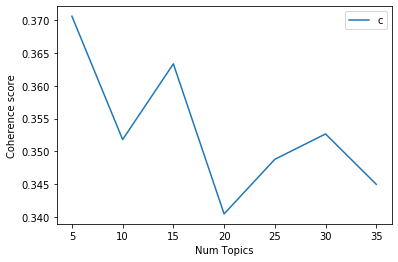

In [24]:
limit=40; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
#plt.savefig('/content/drive/My Drive/Colab Notebooks/FYP/coherence.png')

In [27]:
perplexity_values

[-6.101635985872685,
 -6.101709924329782,
 -6.101536295586079,
 -6.101650234358927,
 -6.10177636361465,
 -6.1017054155672446,
 -6.101703588845749]

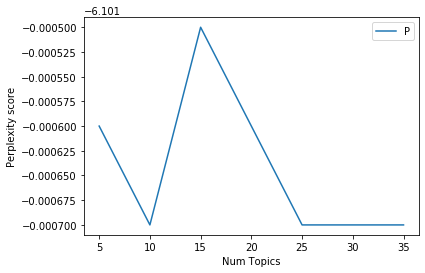

In [32]:
limit=40; start=5; step=5;
x = range(start, limit, step)
plt.plot(x, [-6.1016,-6.1017, -6.1015, -6.1016,-6.1017,-6.1017,-6.1017])#perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("Perplexity_values"), loc='best')
#plt.show()
plt.savefig('/content/drive/My Drive/Colab Notebooks/FYP/Perplexity.png')

In [21]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

##lda_model = model_list[0]
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Per_Cont', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Per_Cont,Keywords,Text
0,0,11.0,0.5958,"datum, personal, mean, process, person, group,...",. This Regulation lays down rules relating...
1,1,10.0,0.8862,"datum, personal, right, process, purpose, arti...",This Regulation protects fundamental rights a...
2,2,10.0,0.9130,"datum, personal, right, process, purpose, arti...",The free movement of personal data within the...
3,3,9.0,0.4742,"part, separate, complainant, benefit, enjoymen...",This Regulation applies to the processing of ...
4,4,10.0,0.8988,"datum, personal, right, process, purpose, arti...",This Regulation does not apply to the process...
5,5,11.0,0.5122,"datum, personal, mean, process, person, group,...",For the processing of personal data by the Un...
6,6,14.0,0.5899,"supervisory, authority, decision, shall, artic...",This Regulation shall be without prejudice to...
7,7,10.0,0.6921,"datum, personal, right, process, purpose, arti...",This Regulation applies to the processing of ...
8,8,10.0,0.8461,"datum, personal, right, process, purpose, arti...",This Regulation applies to the processing of ...
9,9,11.0,0.4776,"datum, personal, mean, process, person, group,...",This Regulation applies to the processing of ...


In [22]:
list_count = df_dominant_topic["Dominant_Topic"].value_counts()
list_count

10.0    90
3.0     68
7.0     59
12.0    49
14.0    47
13.0    17
11.0    10
2.0      9
5.0      5
6.0      5
1.0      4
0.0      4
8.0      2
4.0      1
9.0      1
Name: Dominant_Topic, dtype: int64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """Entry point for launching an IPython kernel.


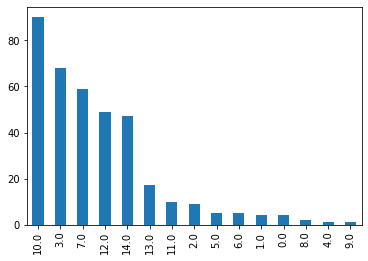

In [24]:
plt = df_dominant_topic["Dominant_Topic"].value_counts().plot("bar")
plt.figure.savefig('/content/drive/My Drive/Colab Notebooks/FYP/#segmentsPerTopic15.png')
#df_dominant_topic["Dominant_Topic"].hist()

In [0]:
df_dominant_topic.to_csv('/content/drive/My Drive/Colab Notebooks/FYP/lawSegmentTopic.csv')

In [0]:
df_dominant_topic.iloc[100]
df_dominant_topic[df_dominant_topic["Dominant_Topic"] == 0]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9911,"datum, controller, shall, personal, member, ar...",. This Regulation lays down rules relating...
1,1,0.0,0.9880,"datum, controller, shall, personal, member, ar...",This Regulation protects fundamental rights a...
2,2,0.0,0.9911,"datum, controller, shall, personal, member, ar...",The free movement of personal data within the...
3,3,0.0,0.9942,"datum, controller, shall, personal, member, ar...",This Regulation applies to the processing of ...
4,4,0.0,0.9970,"datum, controller, shall, personal, member, ar...",This Regulation does not apply to the process...
...,...,...,...,...,...
351,351,0.0,0.9975,"datum, controller, shall, personal, member, ar...",Member States may adopt specific rules to set...
353,353,0.0,0.6913,"datum, controller, shall, personal, member, ar...",Where in a Member State churches and religiou...
354,354,0.0,0.5483,"datum, controller, shall, personal, member, ar...",Churches and religious associations which app...
361,361,0.0,0.9836,"datum, controller, shall, personal, member, ar...",Where reference is made to this paragraph Art...


In [0]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()
#plt.savefig('/content/drive/My Drive/Colab Notebooks/FYP/dist.png')

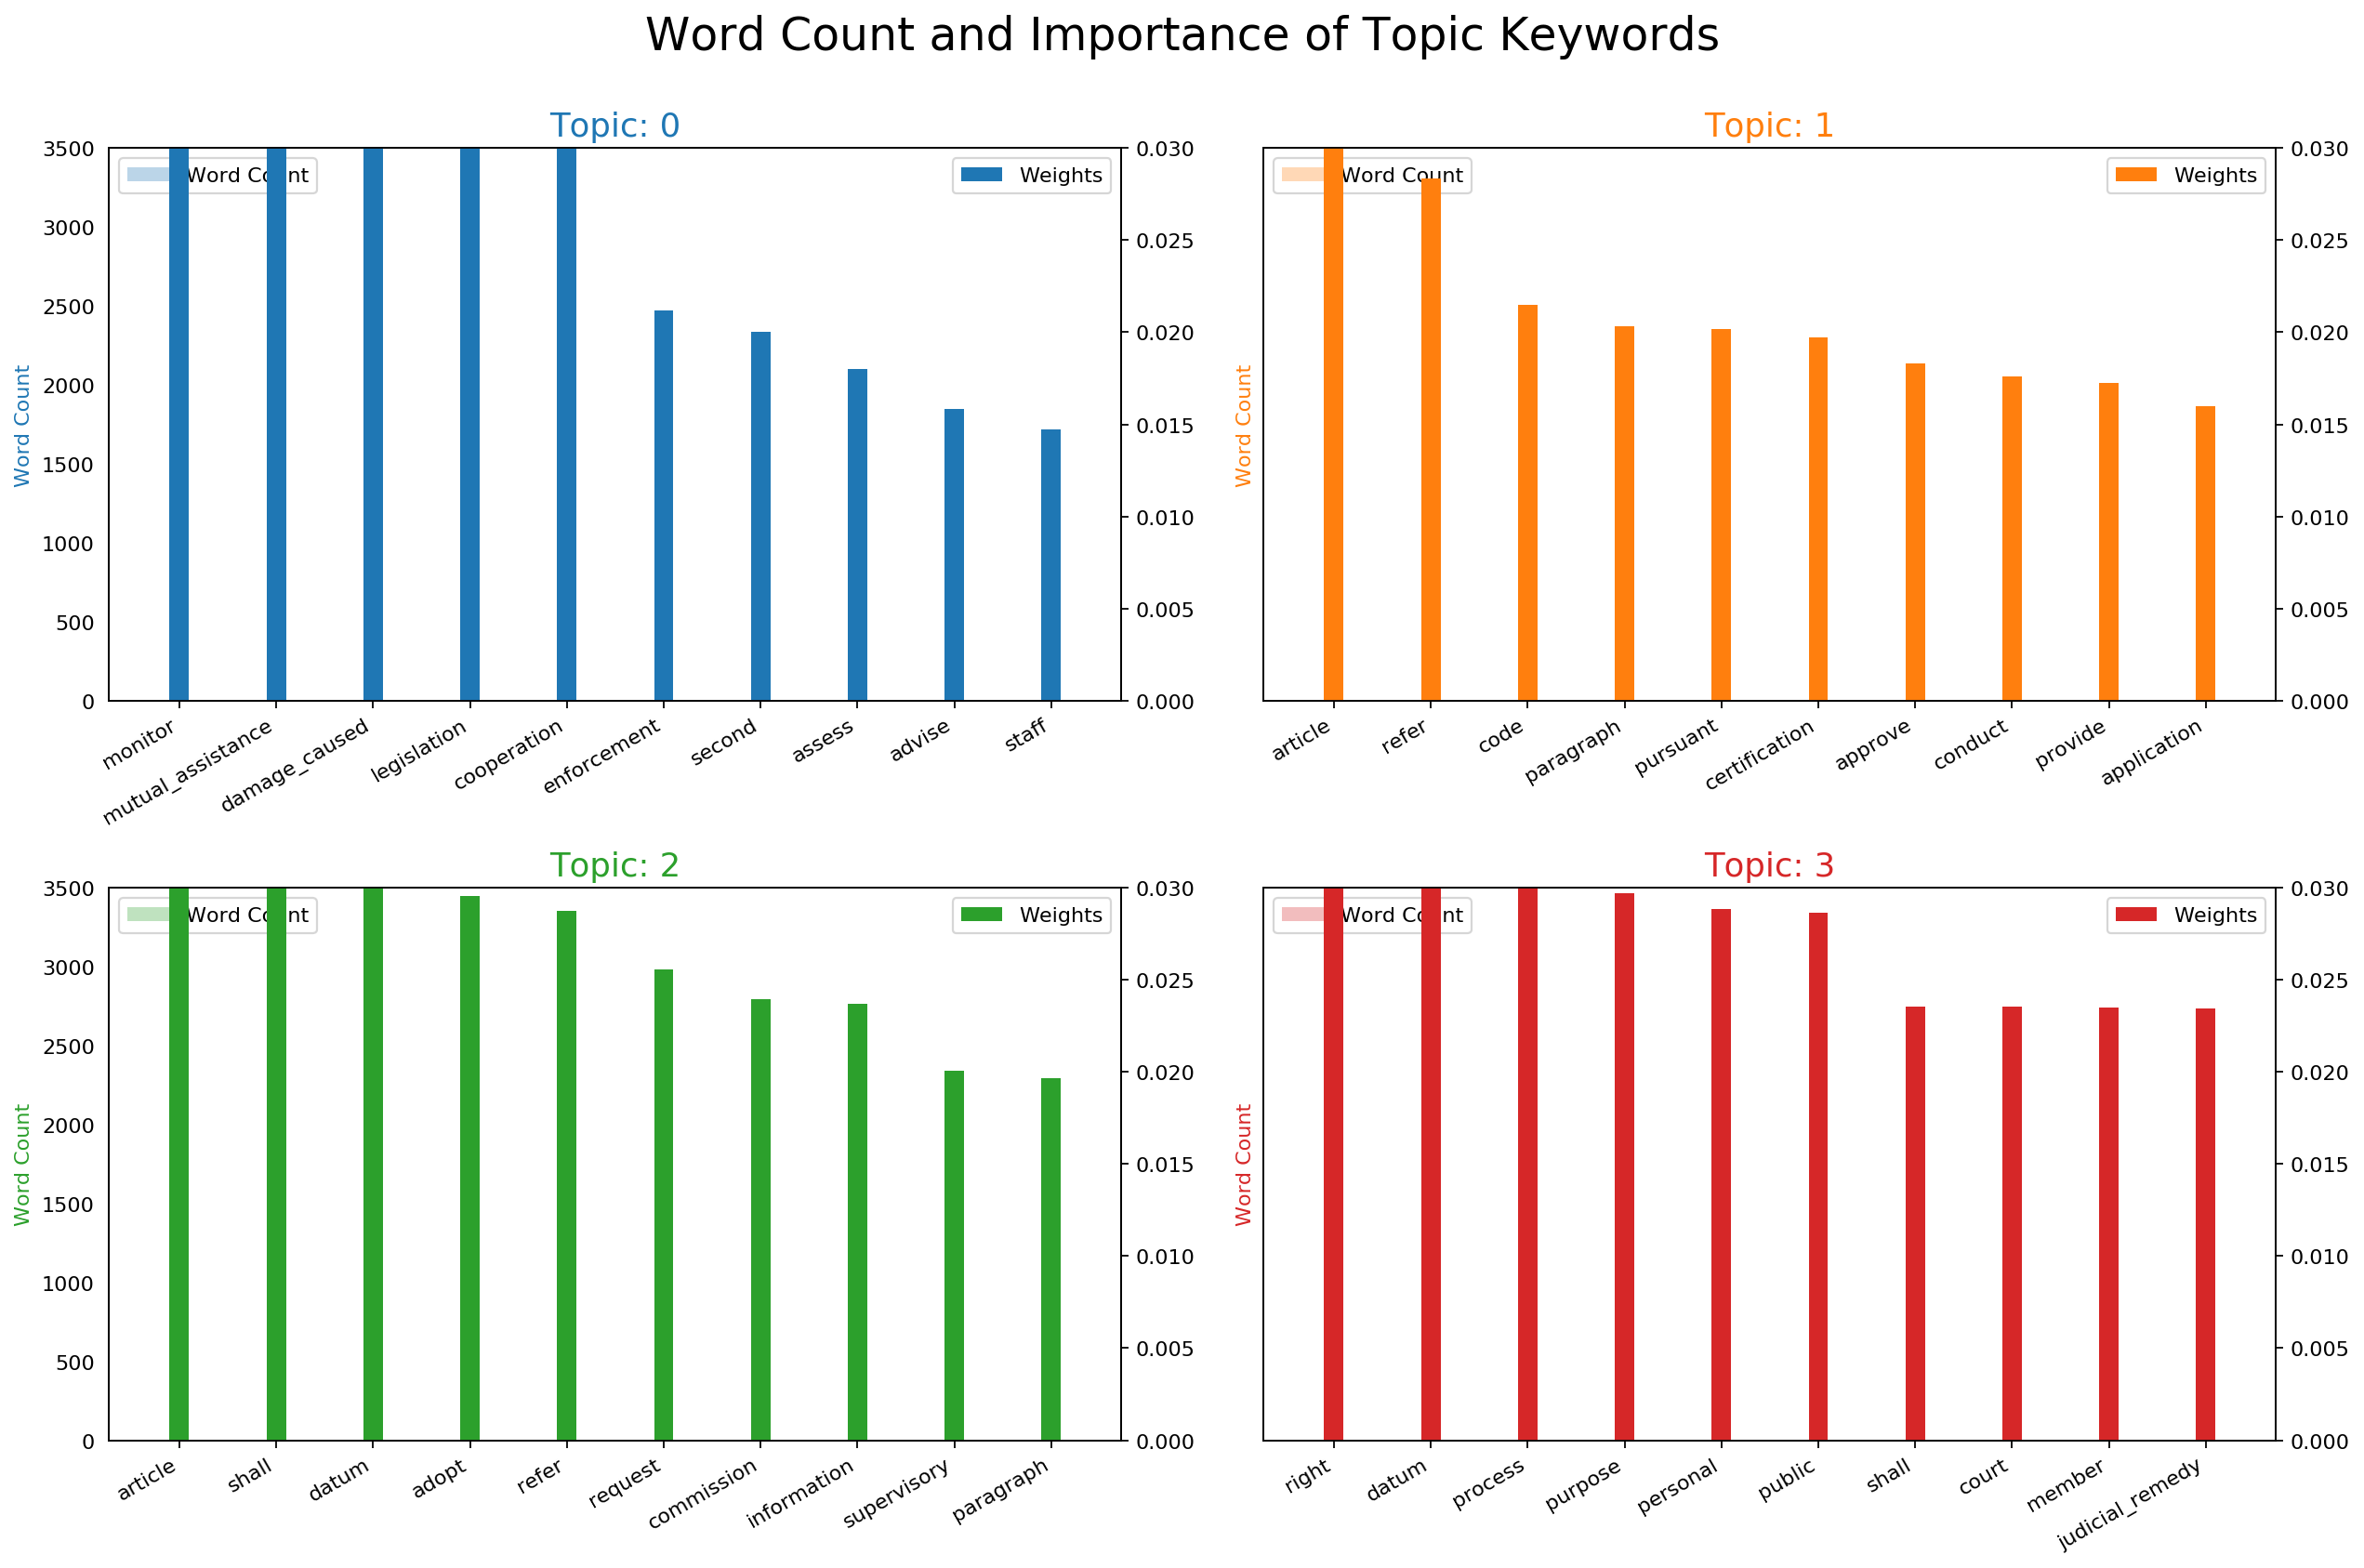

In [0]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()
#plt.savefig('/content/drive/My Drive/Colab Notebooks/FYP/wordCount.png')

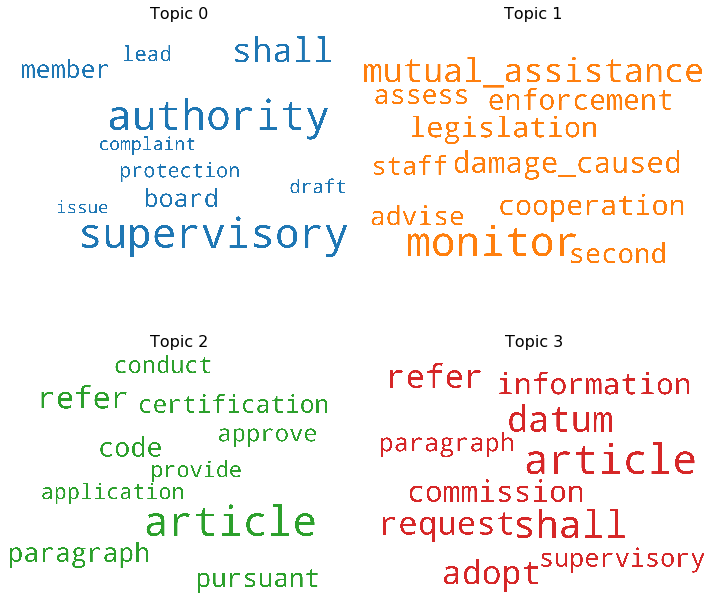

In [0]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
#plt.show()
plt.savefig('/content/drive/My Drive/Colab Notebooks/FYP/mainWords.png')

In [0]:
len(topics)

10

In [0]:
#some articles only have one point, so no numbering is used


In [0]:
file = open("/content/drive/My Drive/Colab Notebooks/FYP/gdpr.txt", "r")
articles = np.empty((0,4))
if file.mode == 'r':
  lines = file.readlines()
  chpt_titles = []
  segments = []
  is_section = False
  chpt_no=0
  sectionName=""
  article_title=False
  is_chpt_title = False
  inside_article = False
  seg_text = ""
  for l in lines:

    if(inside_article): #extract text of articles
      if not(l[0:7] == "Article" and len(l) <=15):
        if(len(l)>5 and l[4].isdigit()):#each point is treated as a separate segement
          if(seg_text!= ""):
            segments.append(seg_text)
            seg_text=""
            l = l[6:len(l)]
        seg_text+=l[0:len(l)-2]+" "

    if(is_chpt_title):
      chpt_titles.append(l[0:len(l)-2])
      is_chpt_title = False
    if(article_title):
      article_title = False
      newRow=[l[0:len(l)-2], chpt_no]
      articles = np.append(articles, [[l[0:len(l)-2],chpt_titles[chpt_no-1],sectionName, chpt_no]], axis=0)
      inside_article = True
    if(is_section):
      is_section = False
      sectionName=l[0:len(l)-2]


    if(l[0:7]== "CHAPTER"):
      print(l)
      chpt_no+=1
      is_chpt_title = True
      sectionName=""
    elif(l[0:7] == "Article" and len(l) <=15):
      print(l)
      article_title = True
      inside_article = False
    elif(l[0:7] == "SECTION" and len(l) <=15):
      print(l)
      is_section = True


chpt_titles
articles


In [0]:
for i in segments :
  print(i, "\n")

In [0]:
segments[4]

' This Regulation does not apply to the processing of personal data:         (a) in the course of an activity which falls outside the scope of Union law;         (b) by the Member States when carrying out activities which fall within the scope of Chapter 2 of Title V of the TEU;         (c) by a natural person in the course of a purely personal or household activity;         (d) by competent authorities for the purposes of the prevention, investigation, detection or prosecution of criminal offences, the execution of criminal penalties, including the safeguarding against and the prevention of threats to public security. '

In [0]:
save = pd.DataFrame(segments)
save.to_csv("/content/drive/My Drive/Colab Notebooks/FYP/gdprSegments.csv")

In [0]:
#failed attempt at graphlab

In [0]:
!pip install GraphLab

ERROR: Could not find a version that satisfies the requirement GraphLab (from versions: none)
ERROR: No matching distribution found for GraphLab


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
data_corpus = ["John likes to watch movies. Mary likes movies too.", 
"John also likes to watch football games."]
X = vectorizer.fit_transform(data_corpus) 
print(X.toarray())
print(vectorizer.get_feature_names())

[[0 0 0 1 2 1 2 1 1 1]
 [1 1 1 1 1 0 0 1 0 1]]
['also', 'football', 'games', 'john', 'likes', 'mary', 'movies', 'to', 'too', 'watch']


In [0]:
import collections, re
texts = ['John likes to watch movies. Mary likes too.',
   'John also likes to watch football games.']
bagsofwords = [ collections.Counter(re.findall(r'\w+', txt))
            for txt in segments]
bagsofwords[1]

Counter({'Regulation': 1,
         'This': 1,
         'and': 2,
         'data': 1,
         'freedoms': 1,
         'fundamental': 1,
         'in': 1,
         'natural': 1,
         'of': 2,
         'particular': 1,
         'personal': 1,
         'persons': 1,
         'protection': 1,
         'protects': 1,
         'right': 1,
         'rights': 1,
         'the': 1,
         'their': 1,
         'to': 1})

In [0]:
import graphlab as gl
m = gl.topic_model.create(bagsofwords, num_topics=30,       # number of topics
                              num_iterations=100,   # algorithm parameters
                              alpha=.01, beta=.1)  # hyperparameters
pred = m.predict(bagsofwords)

ModuleNotFoundError: ignored

In [0]:
segments[1]

' This Regulation protects fundamental rights and freedoms of natural persons and in particular their right to the protection of personal data. '